In [1]:
print("hogehoge")

hogehoge



# 求めたい式
$$
\bm{G} = K \bm{\rho}
$$
この式から$\rho$を導きたい
$$
\frac{1}{2} ||\bm{G} - K \bm{\rho}||_2^2
$$
  
ここで、観測行列Kを特異値分解 $K = USV^{\dagger}$ し、上式に代入
$$
\frac{1}{2} ||\bm{G} -  USV^{\dagger} \bm{\rho}||_2^2
$$
  ここで、左から　$U^{\dagger}$　を作用させる
$$
\frac{1}{2} ||U^{\dagger} \bm{G} -  U^{\dagger} USV^{\dagger} \bm{\rho}||_2^2
$$
  ここで、$U^{\dagger} U = 1$である。
  $U^{\dagger} \bm{G} = \bm{G'}$、$V^{\dagger} \bm{\rho} = \bm{\rho'}$
  と再定義する
$$
\frac{1}{2} ||\bm{G'} - S \bm{\rho'}||_2^2
$$
ここからlasso
$$
\min_{\rho'}{(\frac{1}{2} ||\bm{G'} - S \bm{\rho'}||_2^2 + \lambda||\rho'||_1)}
$$
$\bm{G'} = \bm{y}, \bm{\rho'} = \bm{x}, \bm{S} = \bm{A},$
  に対応させる
$$ ↓$$

$$
\min_{x}{(\frac{1}{2} ||\bm{y} - A \bm{x}||_2^2 + \lambda||x||_1)}
$$

ADMMを用いてxを再構成する


# パラメータの設定

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#パメータの設定
M = 5
N = 10
ep = 1e-6

In [3]:
#原信号x0の設定
rho = 0.1
x0 = np.random.randn(N)
mask = (np.random.rand(N) < rho)
x0 = mask*x0

In [4]:
#観測行列Aの設定
A = np.random.randn(M,N)

#Aの特異値分解
U, S, Vt = np.linalg.svd(A, full_matrices=False)

#特異値を指数関数的に減少させ、観測行列A_expの構成
a = np.linspace(0, 20, min(M,N))
lam = np.exp(-a)
S_exp = S * lam
A_exp = U @ np.diag(S_exp) @ Vt


U_, S_, Vt_ = np.linalg.svd(A_exp, full_matrices=False)

In [5]:
mse = np.mean((S_ - S_exp)*2)
mse

-3.957920767649141e-16

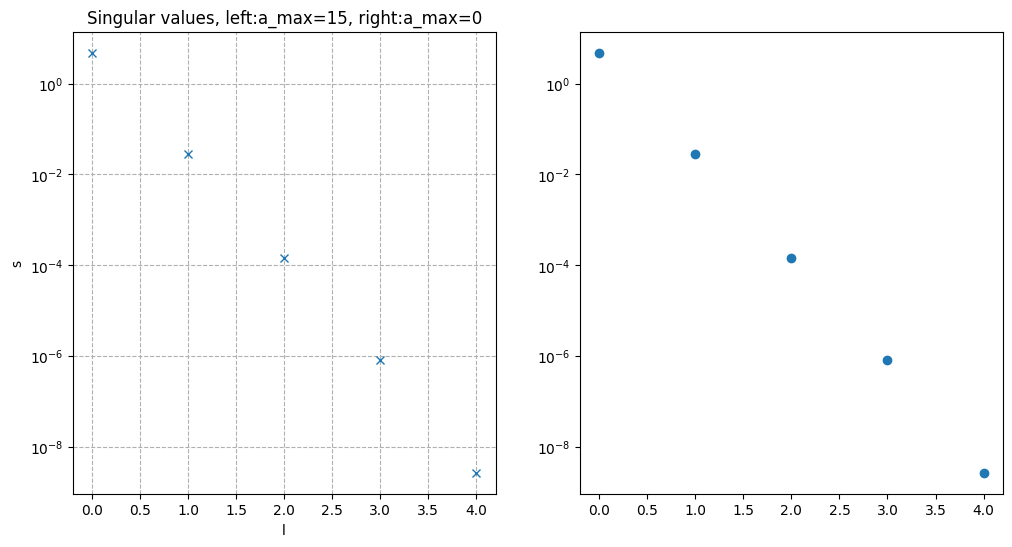

In [6]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)
ax1.semilogy(S_exp, 'o')
ax2.semilogy(S_, 'x')
plt.xlabel('l')
plt.ylabel('s')
plt.title('Singular values, left:a_max=15, right:a_max=0')
plt.grid(True, which="both", ls="--")
plt.show()

In [7]:
np.diag(S)

array([[4.78192124, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 4.15390315, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 3.10339159, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.61268243, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.29151939]])

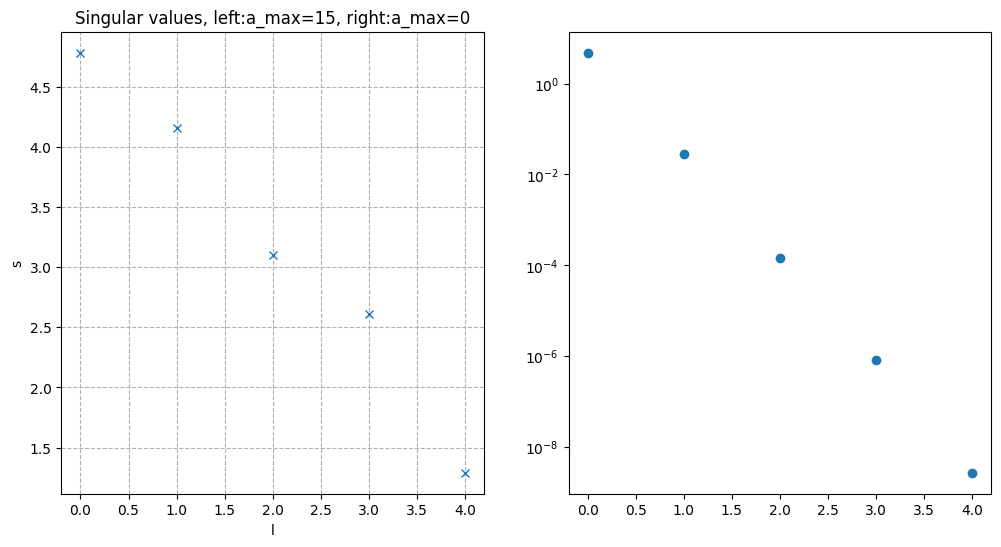

In [8]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)
ax1.semilogy(S_exp, 'o')
ax2.plot(S, 'x')
plt.xlabel('l')
plt.ylabel('s')
plt.title('Singular values, left:a_max=15, right:a_max=0')
plt.grid(True, which="both", ls="--")
plt.show()


In [9]:
#観測信号yの設定
y = A.dot(x0)
y_exp = A_exp.dot(x0)

# ADMM for lasso 

In [10]:
#軟判定閾値関数の設定
def SoftThr(v, thr):
    z = np.zeros(len(v))
    itemp = np.where(v > thr)
    z[itemp]  = v[itemp] -thr
    itemp = np.where(v <= -thr)
    z[itemp] = v[itemp] + thr

    return z

In [11]:
def opt_admm(x, y, A, x0, Tall=10, p=10.0, flag=True):
    M, N = A.shape  # Aのサイズを取得
    #Atemp = A.dot(A.T)
    Atemp = A.dot(A.T) + ep * np.eye(M)
    Ainv = np.linalg.inv(Atemp)
    Atemp = A.T.dot(Ainv)

    #更新パラメータの設定
    Nvec = len(x)
    z = np.zeros(Nvec)
    u = np.zeros(Nvec)
    mse_list = []


    #更新パラメータx,z,u,の更新則
    for t in range(Tall):
        x = Atemp.dot(y) + (np.eye(Nvec) - Atemp.dot(A)).dot(z + u)
        z = SoftThr(x-u, 1/p)
        u = u + (z-x)

        #平均二乗誤差
        mse = np.mean((x - x0) ** 2)
        mse_list.append(mse)

      
        # if flag == True:
        #     clear_output(True)
        #     plt.scatter(range(len(x)), x, label='x', color='blue', marker='x')
        #     plt.scatter(range(len(x)), x0, label='x0', color='red')
        #     plt.xlabel('Index')
        #     plt.ylabel('Value')
        #     plt.legend()
        #     plt.show()
               
    return x, mse_list

In [12]:
(A.dot(A.T) + ep * np.eye(M)).shape

(5, 5)

In [13]:
x = np.zeros(N)
x, mse_list = opt_admm(x,y,A,x0,Tall=100)
x_ = np.zeros(N)
x_, exp_mse_list = opt_admm(x_, y_exp, A_exp, x0, Tall=100)


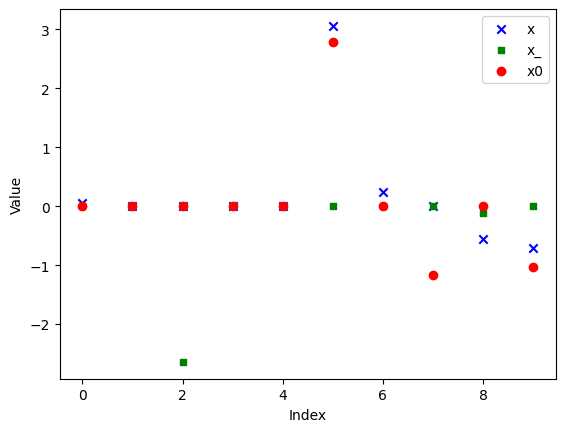

In [14]:
plt.scatter(range(len(x)), x, label='x', color='blue', marker='x')
plt.scatter(range(len(x_)), x_, label='x_', color='green', marker='s', s=15)
plt.scatter(range(len(x_)), x0, label='x0', color='red')
# plt.semilogy(range(len(x_)), x_, label='x_', color='green', marker='s')
# plt.semilogy(range(len(x_)), x0, label='x0', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

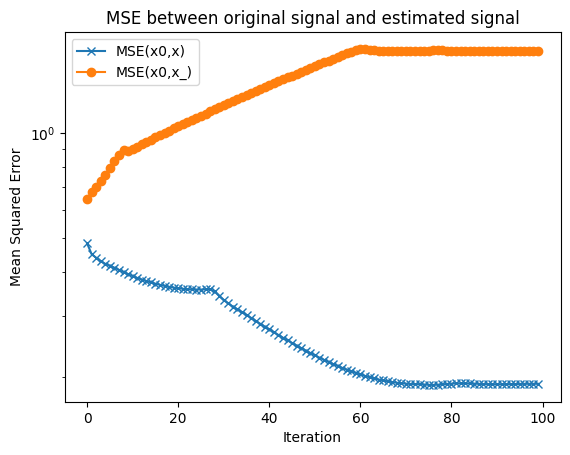

In [15]:
#平均二乗誤差のプロット
plt.figure()
plt.semilogy(mse_list, label='MSE(x0,x)',marker='x')
plt.semilogy(exp_mse_list, label='MSE(x0,x_)',marker='o')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('MSE between original signal and estimated signal')
plt.legend()
plt.show()

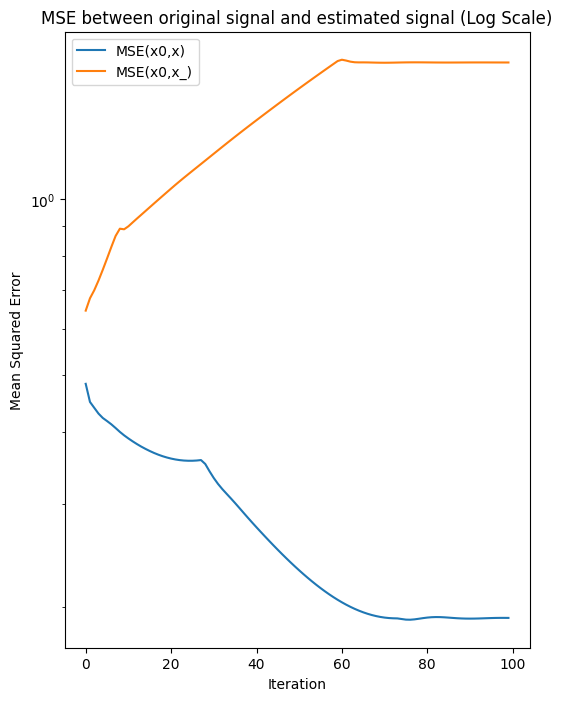

In [16]:
# 平均二乗誤差のプロット
plt.figure(figsize=(6,8))
plt.plot(range(len(mse_list)), mse_list, label='MSE(x0,x)')
plt.plot(range(len(exp_mse_list)), exp_mse_list, label='MSE(x0,x_)')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.yscale('log')  # y軸を対数スケールに設定
plt.title('MSE between original signal and estimated signal (Log Scale)')
plt.legend()
plt.show()


# 再構成の成功相と失敗相の相図

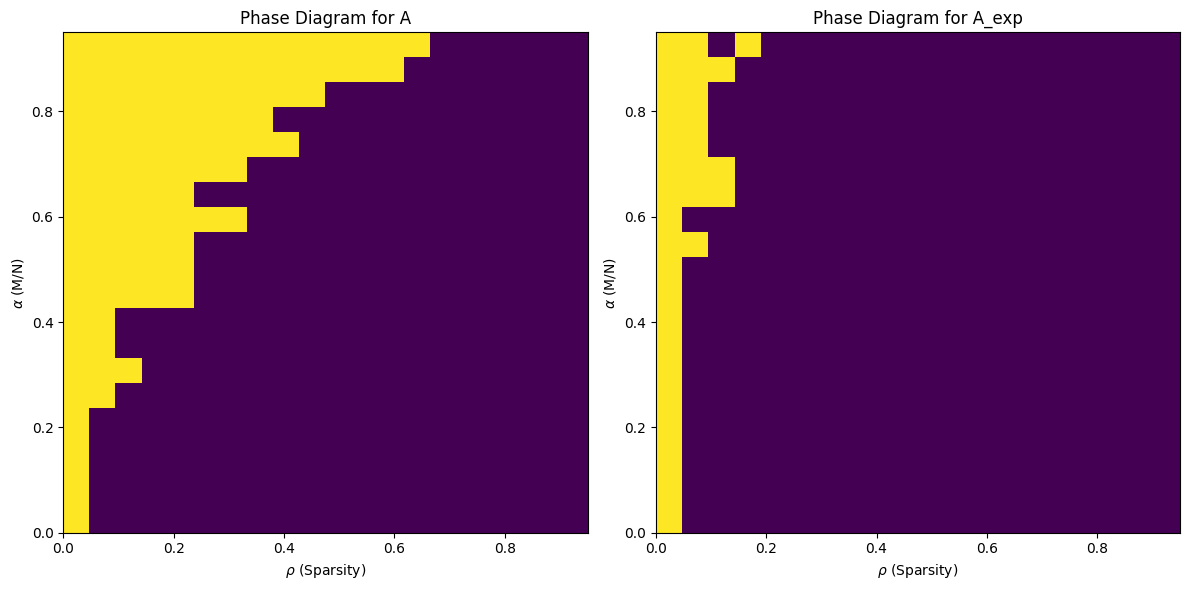

In [17]:
# ρとMの範囲
rho_values = np.arange(0.00, 1.00, 0.05)
M_values = np.arange(0, 100, 5)
N = 100
alpha_values = M_values / N

# 結果を保存する配列
phase_diagram_A = np.zeros((len(M_values), len(rho_values)))
phase_diagram_A_exp = np.zeros((len(M_values), len(rho_values)))

# 繰り返し計算
for i, rho in enumerate(rho_values):
    for j, M in enumerate(M_values):
        # 原信号x0の設定
        x0 = np.random.randn(N)
        mask = (np.random.rand(N) < rho)
        x0 = mask * x0

        # 観測行列Aの設定
        A = np.random.randn(M, N)

        # Aの特異値分解
        U, S, Vt = np.linalg.svd(A, full_matrices=False)

        # 特異値を指数関数的に縮小し、A_expを設定
        a = np.linspace(0, 15, min(M, N))
        lam = np.exp(-a)
        S_exp = S * lam
        A_exp = U @ np.diag(S_exp) @ Vt

        # 観測信号yの設定
        y = A.dot(x0)
        y_exp = A_exp.dot(x0)

        # 初期設定
        x = np.zeros(N)
        x_ = np.zeros(N)

        # ADMMを実行
        x, mse_list_A = opt_admm(x, y, A, x0, Tall=100)
        x_, mse_list_A_exp = opt_admm(x_, y_exp, A_exp, x0, Tall=100)

        # MSEが1e-5以下かどうかを判定
        if mse_list_A[-1] <= 1e-7:
            phase_diagram_A[j, i] = 1  # 推定可能
        else:
            phase_diagram_A[j, i] = 0  # 推定不可能

        if mse_list_A_exp[-1] <= 1e-7:
            phase_diagram_A_exp[j, i] = 1  # 推定可能
        else:
            phase_diagram_A_exp[j, i] = 0  # 推定不可能
            
# 相図を作成
plt.figure(figsize=(12, 6))

# LaTeXの設定を有効にする
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 12

# Aの相図
plt.subplot(1, 2, 1)
plt.imshow(phase_diagram_A, extent=[rho_values.min(), rho_values.max(), alpha_values.min(), alpha_values.max()], aspect='auto', origin='lower', cmap='viridis')
#plt.colorbar(label='Estimable (1) or Not (0)')
plt.xlabel(r'$\rho$ (Sparsity)')
plt.ylabel(r'$\alpha$ (M/N)')
plt.title('Phase Diagram for A')

# A_expの相図
plt.subplot(1, 2, 2)
plt.imshow(phase_diagram_A_exp, extent=[rho_values.min(), rho_values.max(), alpha_values.min(), alpha_values.max()], aspect='auto', origin='lower', cmap='viridis')
#plt.colorbar(label='Estimable (1) or Not (0)')
plt.xlabel(r'$\rho$ (Sparsity)')
plt.ylabel(r'$\alpha$ (M/N)')
plt.title('Phase Diagram for A_exp')

plt.tight_layout()
plt.show()


# 再構成の相図(a_maxを変動できるようにした)

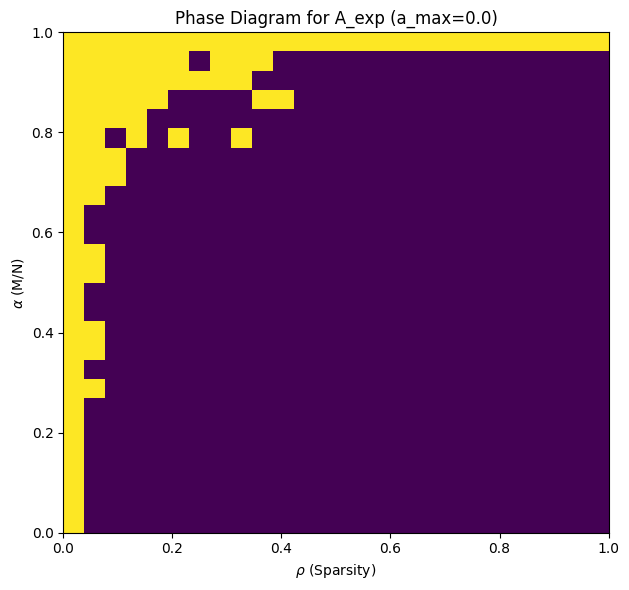

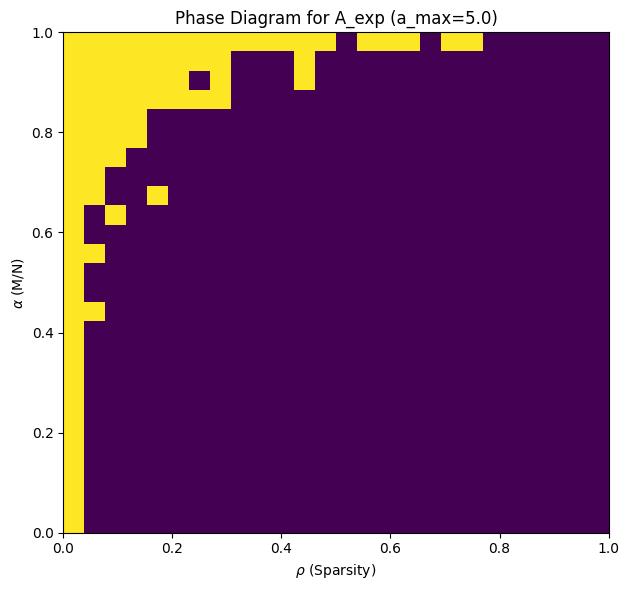

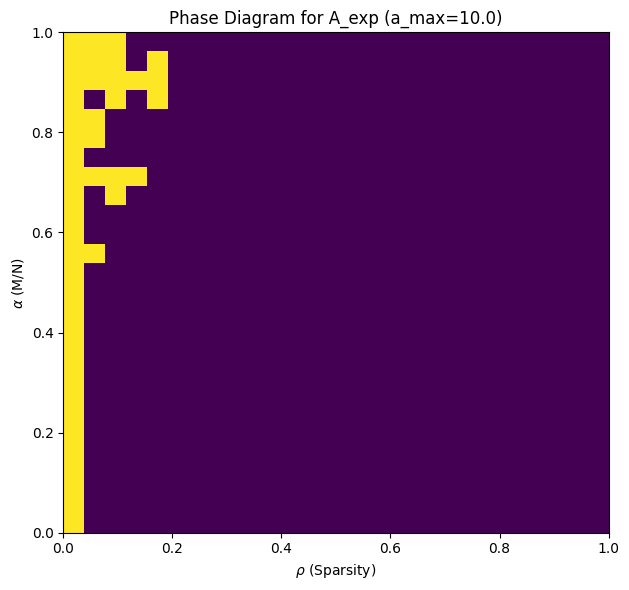

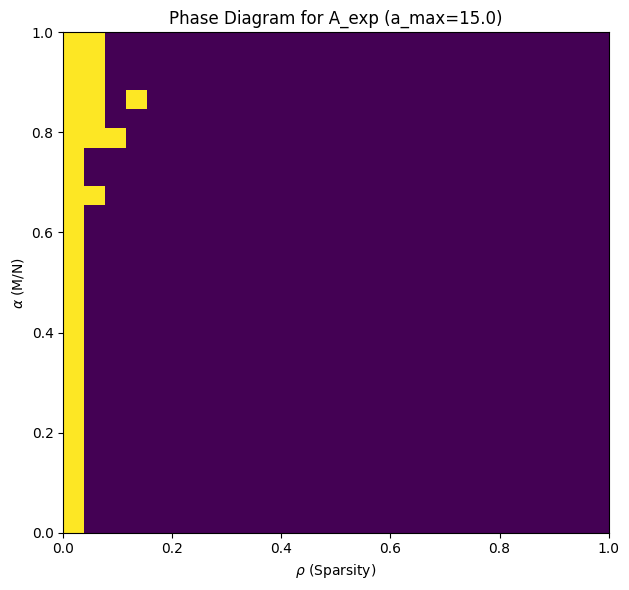

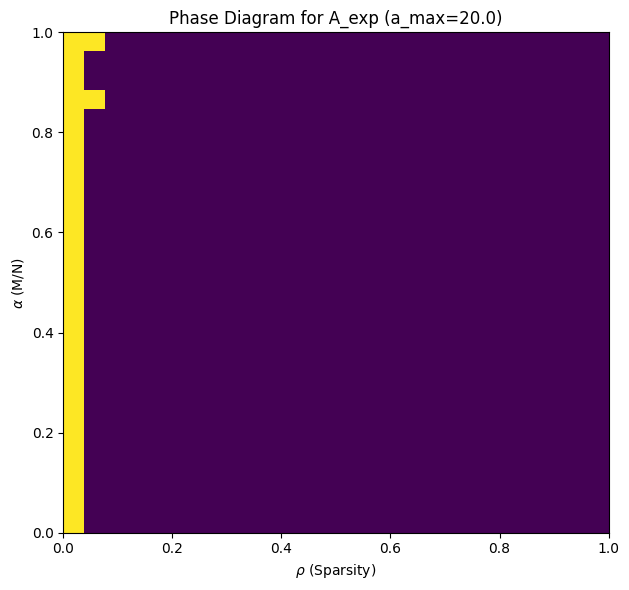

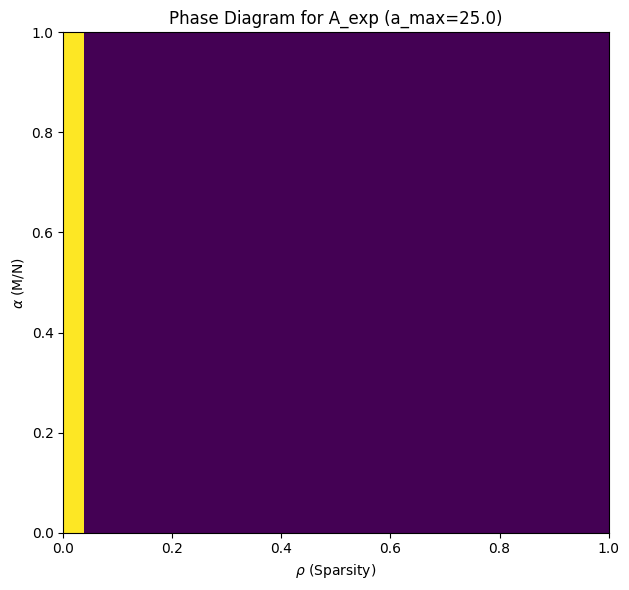

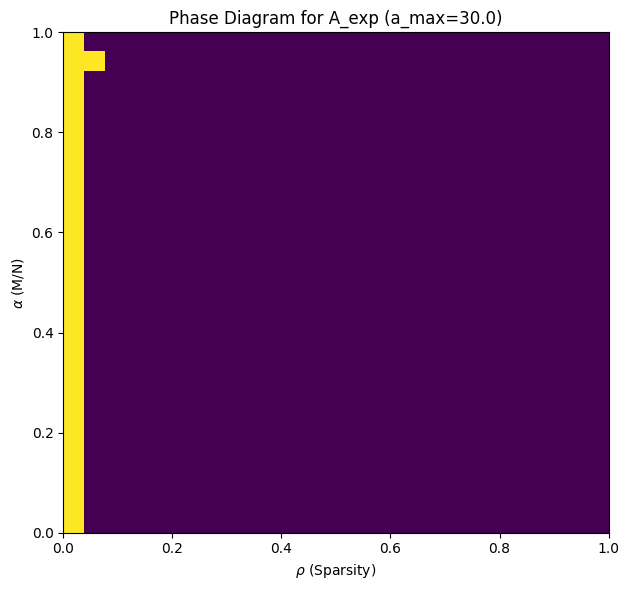

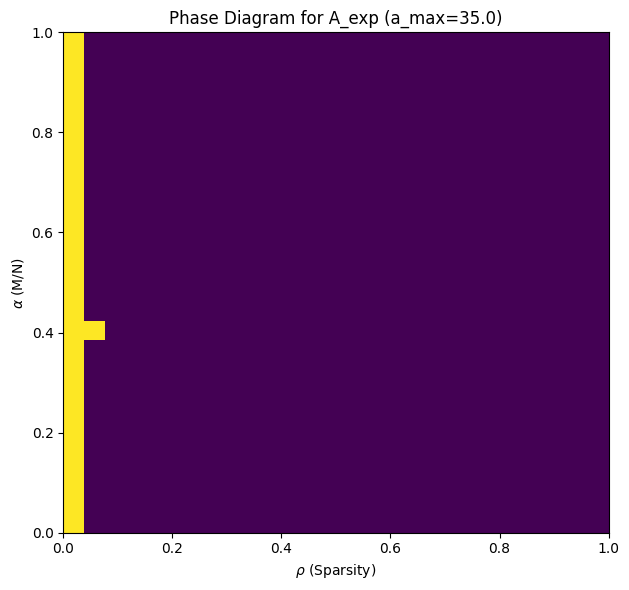

In [18]:
# ρとMの範囲
rho_values = np.arange(0.0, 1.01, 0.04)
M_values = np.arange(0, 101, 4)
N = 100
alpha_values = M_values / N

# 縮小するaの範囲
a_values = np.arange(0, 35.1, 5)

# 繰り返し計算
for a_max in a_values:
    # 結果を保存する配列
    phase_diagram_A_exp = np.zeros((len(alpha_values), len(rho_values)))
    # 繰り返し計算
    for i, rho in enumerate(rho_values):
        for j, M in enumerate(M_values):
            # 原信号x0の設定
            x0 = np.random.randn(N)
            mask = (np.random.rand(N) < rho)
            x0 = mask * x0

            # 観測行列Aの設定
            A = np.random.randn(M, N)

            # Aの特異値分解
            U, S, Vt = np.linalg.svd(A, full_matrices=False)

            # 特異値を指数関数的に縮小し、A_expを設定
            a = np.linspace(0, a_max, min(M, N))
            lam = np.exp(-a)
            S_exp = S * lam
            A_exp = U @ np.diag(S_exp) @ Vt

            # 観測信号yの設定
            y = A.dot(x0)
            y_exp = A_exp.dot(x0)

            # 初期設定
            #x = np.zeros(N)
            x_ = np.zeros(N)

            # ADMMを実行
            x_, mse_list_A_exp = opt_admm(x_, y_exp, A_exp, x0, Tall=10)

            # MSEが1e-5以下かどうかを判定
            if mse_list_A_exp[-1] <= 1e-5:
                phase_diagram_A_exp[j, i] = 1  # 推定可能
            else:
                phase_diagram_A_exp[j, i] = 0  # 推定不可能

    # 相図を作成
    plt.figure(figsize=(12, 6))
    # # A_expの相図
    plt.subplot(122)
    plt.imshow(phase_diagram_A_exp, extent=[rho_values.min(), rho_values.max(), alpha_values.min(), alpha_values.max()], aspect='auto', origin='lower', cmap='viridis')
    #plt.colorbar(label='Estimable (1) or Not (0)')
    plt.xlabel(r'$\rho$ (Sparsity)')
    plt.ylabel(r'$\alpha$ (M/N)')
    plt.title(f'Phase Diagram for A_exp (a_max={a_max})')

    plt.tight_layout()
    plt.show()





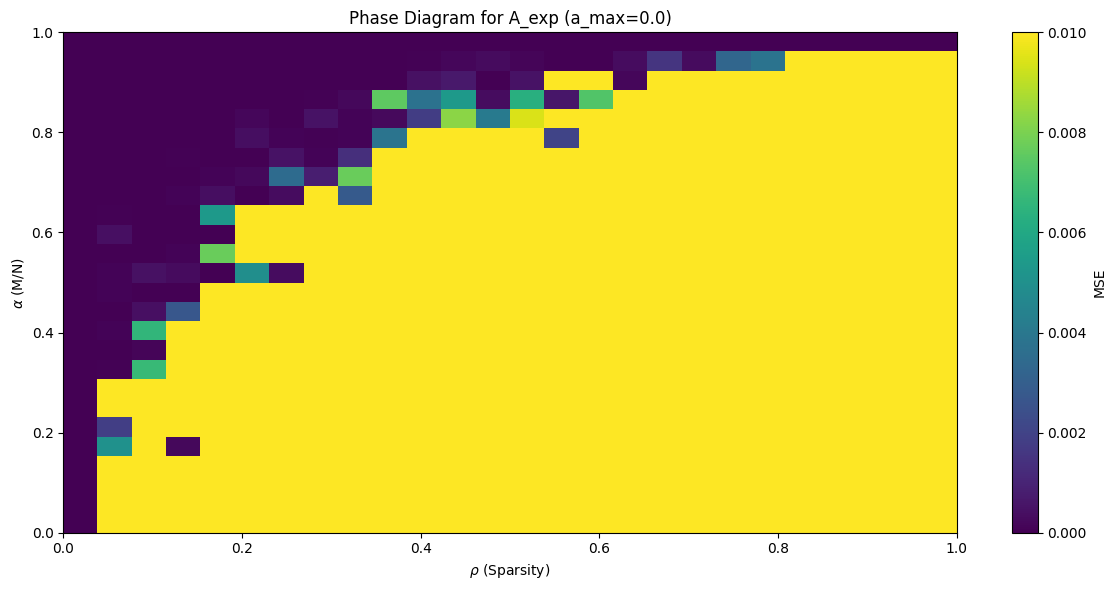

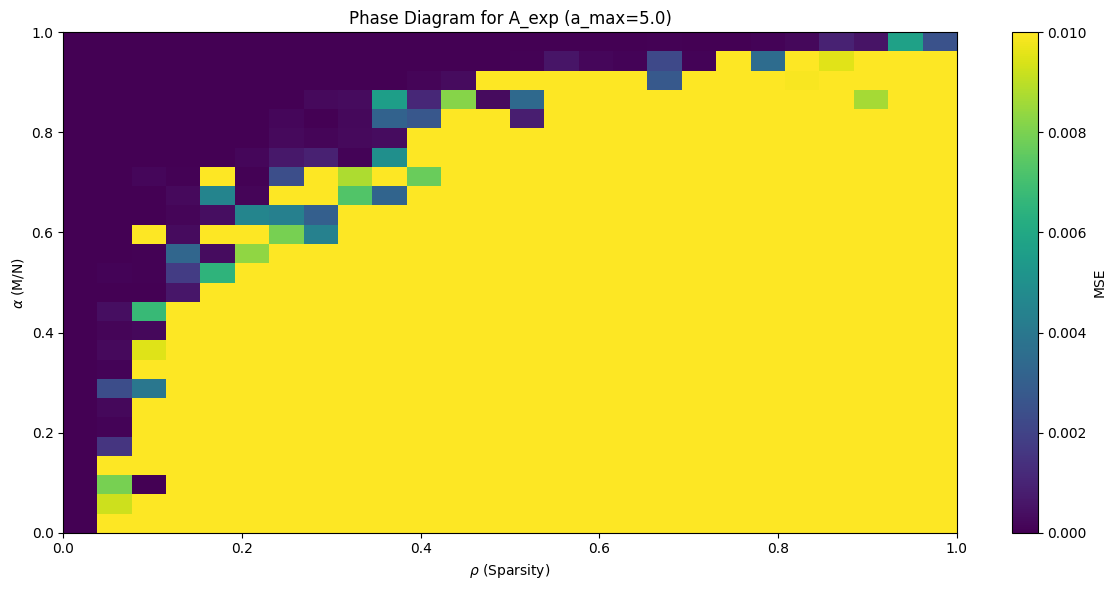

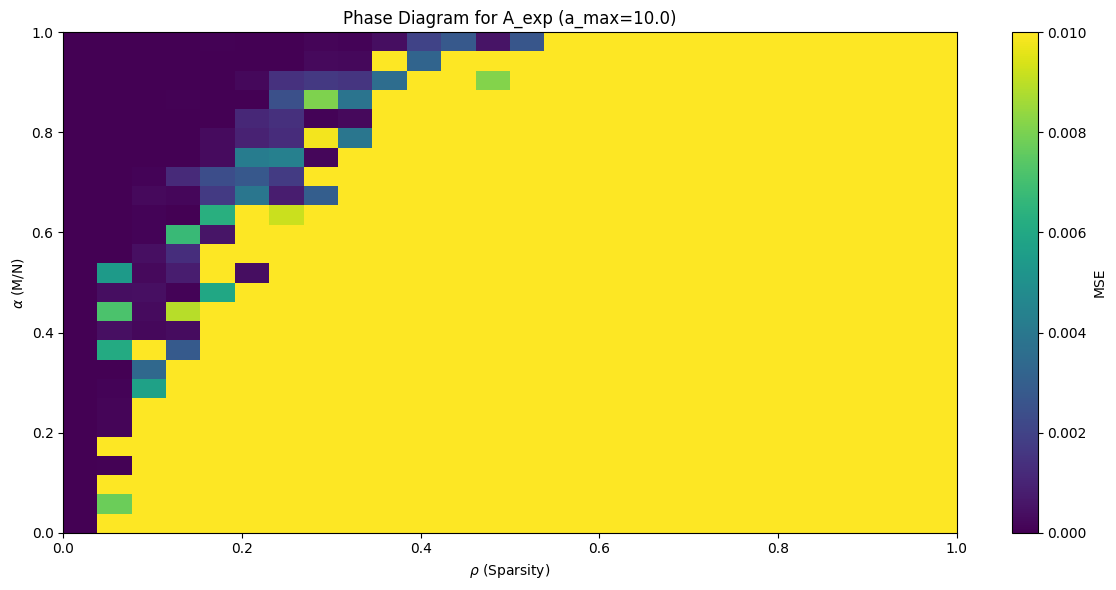

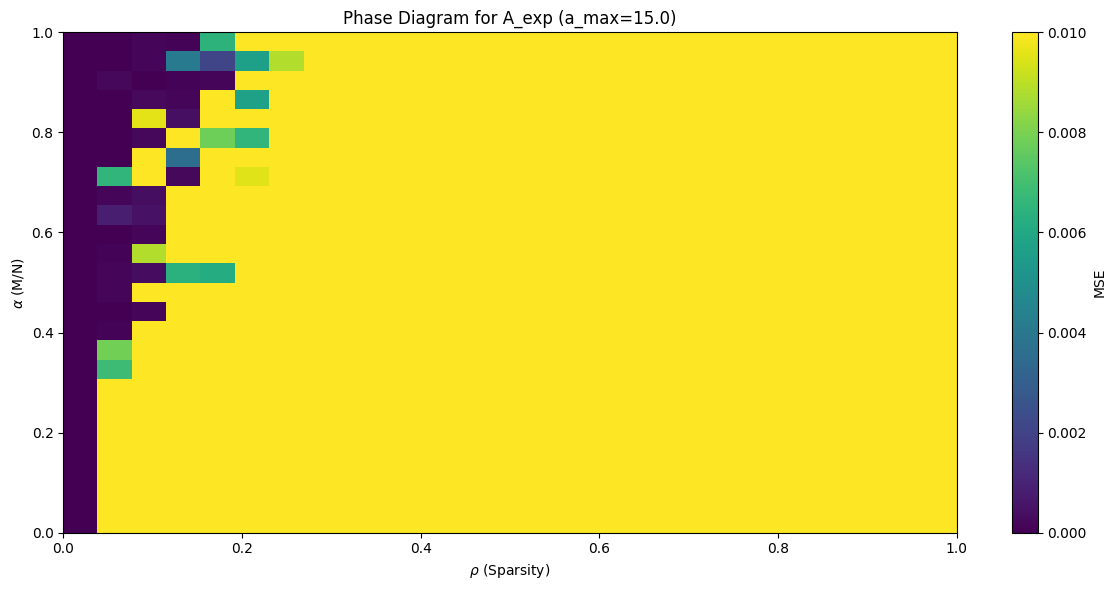

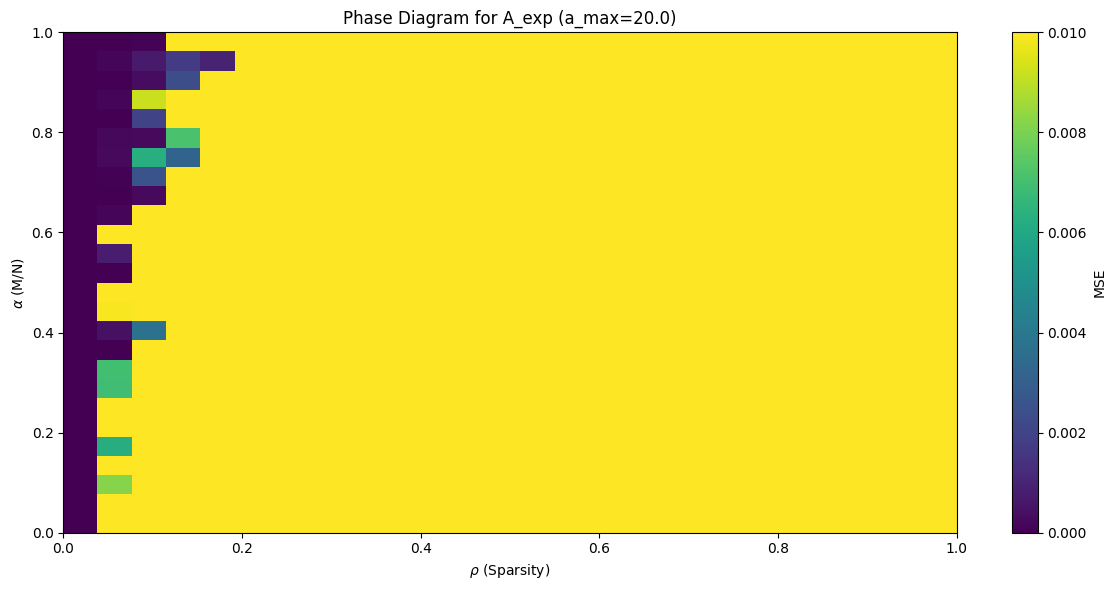

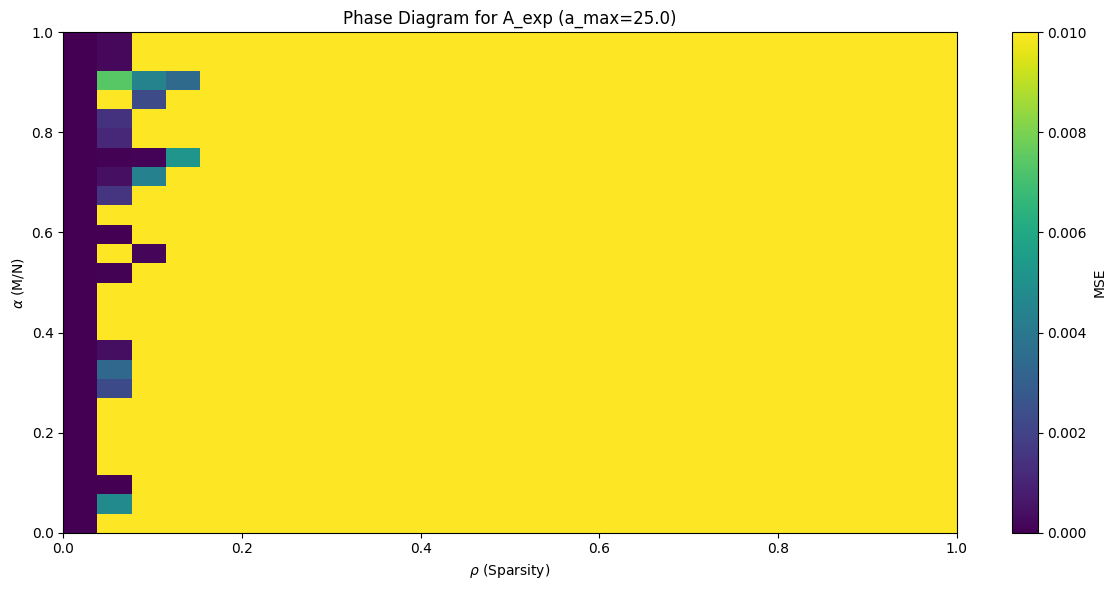

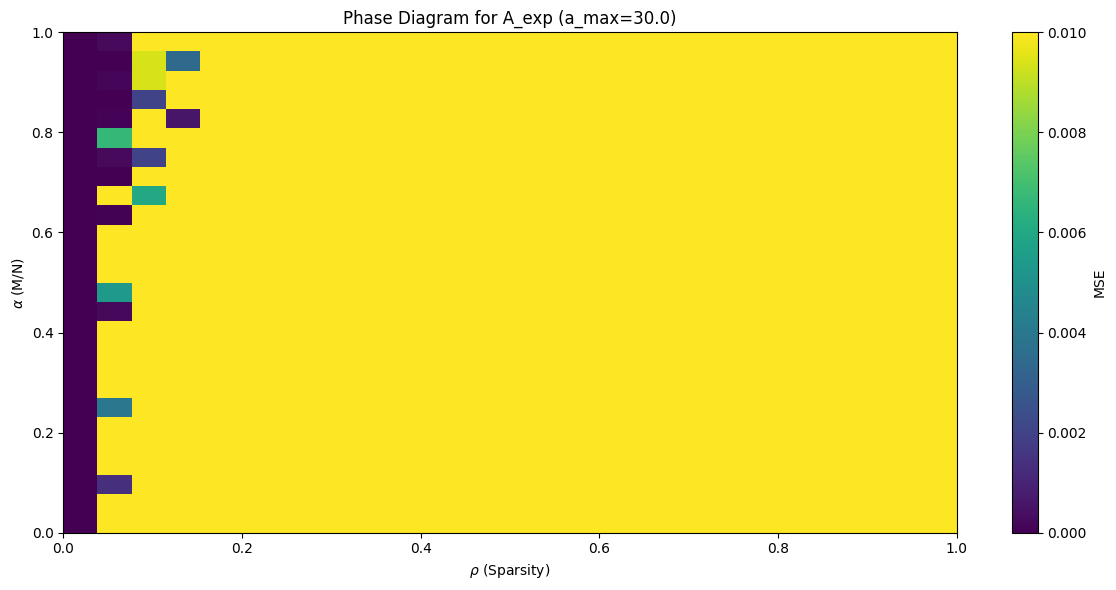

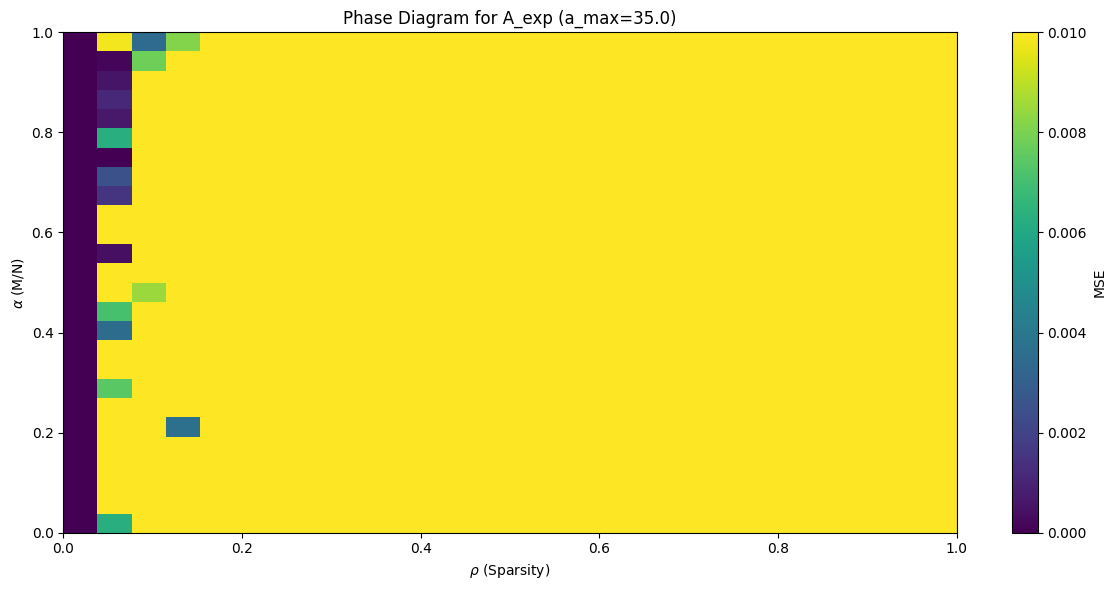

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ρとMの範囲
rho_values = np.arange(0.0, 1.01, 0.04)
M_values = np.arange(0, 101, 4)
N = 100
alpha_values = M_values / N

# 縮小するaの範囲
a_values = np.arange(0, 35.1, 5)

# 繰り返し計算
for a_max in a_values:
    # 結果を保存する配列
    phase_diagram_A_exp = np.zeros((len(alpha_values), len(rho_values)))
    # 繰り返し計算
    for i, rho in enumerate(rho_values):
        for j, M in enumerate(M_values):
            # 原信号x0の設定
            x0 = np.random.randn(N)
            mask = (np.random.rand(N) < rho)
            x0 = mask * x0

            # 観測行列Aの設定
            A = np.random.randn(M, N)

            # Aの特異値分解
            U, S, Vt = np.linalg.svd(A, full_matrices=False)

            # 特異値を指数関数的に縮小し、A_expを設定
            a = np.linspace(0, a_max, min(M, N))
            lam = np.exp(-a)
            S_exp = S * lam
            A_exp = U @ np.diag(S_exp) @ Vt

            # 観測信号yの設定
            y = A.dot(x0)
            y_exp = A_exp.dot(x0)

            # 初期設定
            x_ = np.zeros(N)

            # ADMMを実行
            x_, mse_list_A_exp = opt_admm(x_, y_exp, A_exp, x0, Tall=10)

            # MSEを保存
            phase_diagram_A_exp[j, i] = mse_list_A_exp[-1]

    # 相図を作成
    plt.figure(figsize=(12, 6))
    # A_expの相図
    plt.imshow(phase_diagram_A_exp, extent=[rho_values.min(), rho_values.max(), alpha_values.min(), alpha_values.max()], aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1e-2)
    plt.colorbar(label='MSE')
    plt.xlabel(r'$\rho$ (Sparsity)')
    plt.ylabel(r'$\alpha$ (M/N)')
    plt.title(f'Phase Diagram for A_exp (a_max={a_max})')

    plt.tight_layout()
    plt.show()


# a_max、Mごとの特異値の様子

In [20]:
def plot_singular_values_exponential_decay(a_max_values, M_values, N=100):
    """
    a_max_values: List of maximum values for 'a'
    M_values: List of values for 'M'
    N: Number of columns in observation matrix A (default: 100)
    """
    for a_max in a_max_values:
        plt.figure(figsize=(12, 6))

        for M in M_values:
            # 観測行列Aの設定
            A = np.random.randn(M, N)
            
            # Aの特異値分解
            U, S, Vt = np.linalg.svd(A, full_matrices=False)
            
            # 特異値を指数関数的に縮小し、A'を設定
            a = np.linspace(0, a_max, min(M, N))
            lam = np.exp(-a)  # 指数関数的に減少する特異値

            # Sの大きさに合わせてlamを調整
            S_exp = lam * S[:len(lam)]

            # プロット
            plt.semilogy(S_exp, label=f'M={M}', marker='o')

        # プロットの設定
        plt.xlabel('Index')
        plt.ylabel('Singular Value (log scale)')
        plt.title(f'Exponentially Decayed Singular Values for a_max={a_max} (Log Scale)')
        plt.legend()
        plt.grid(True, which="both", ls="--")

        # グラフを表示
        plt.show()


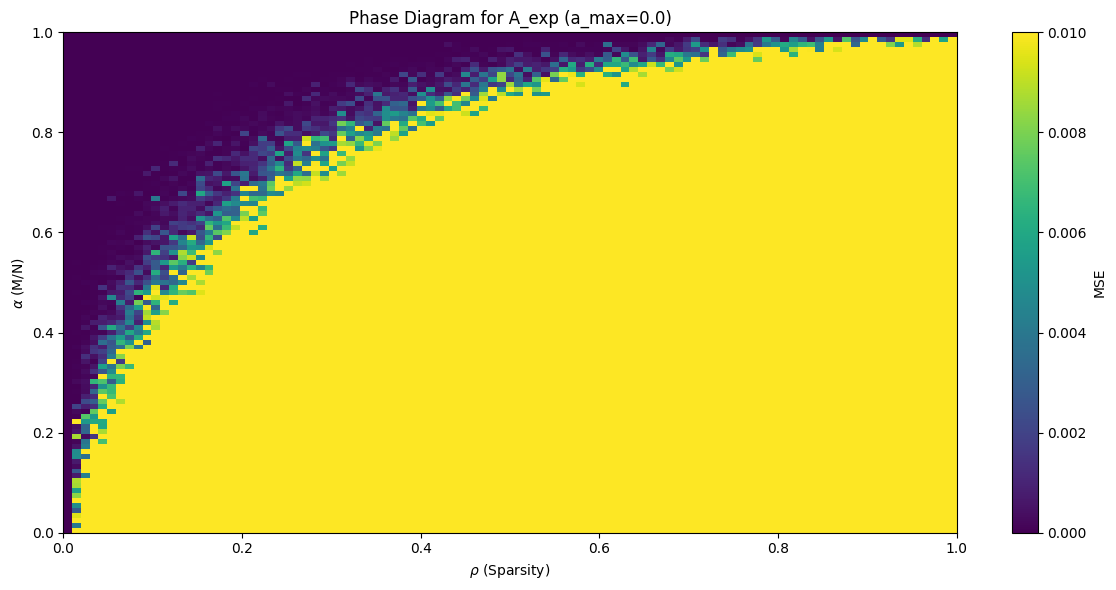

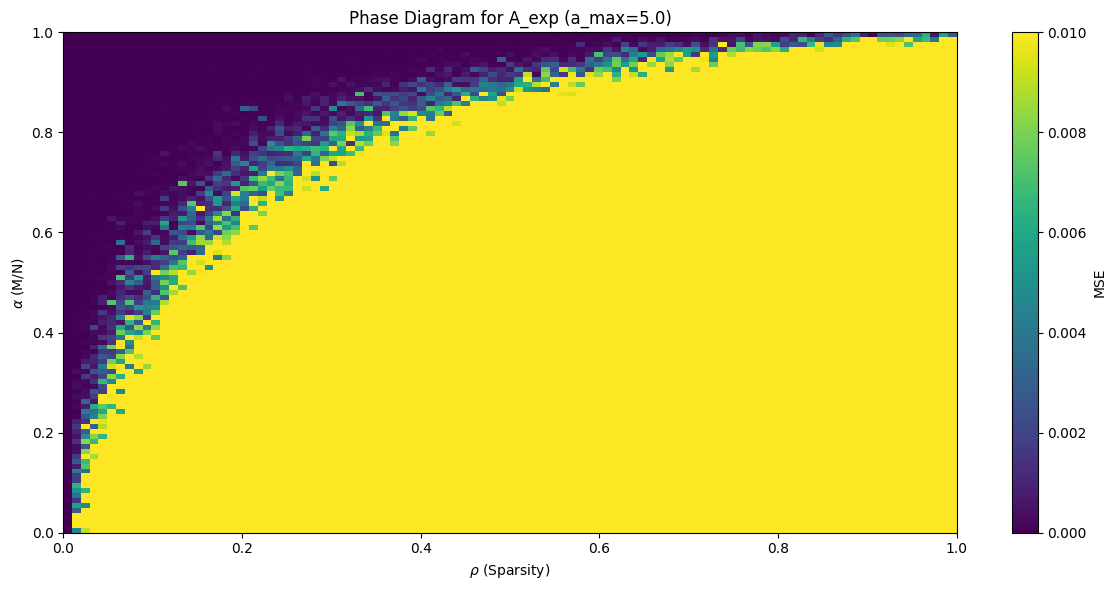

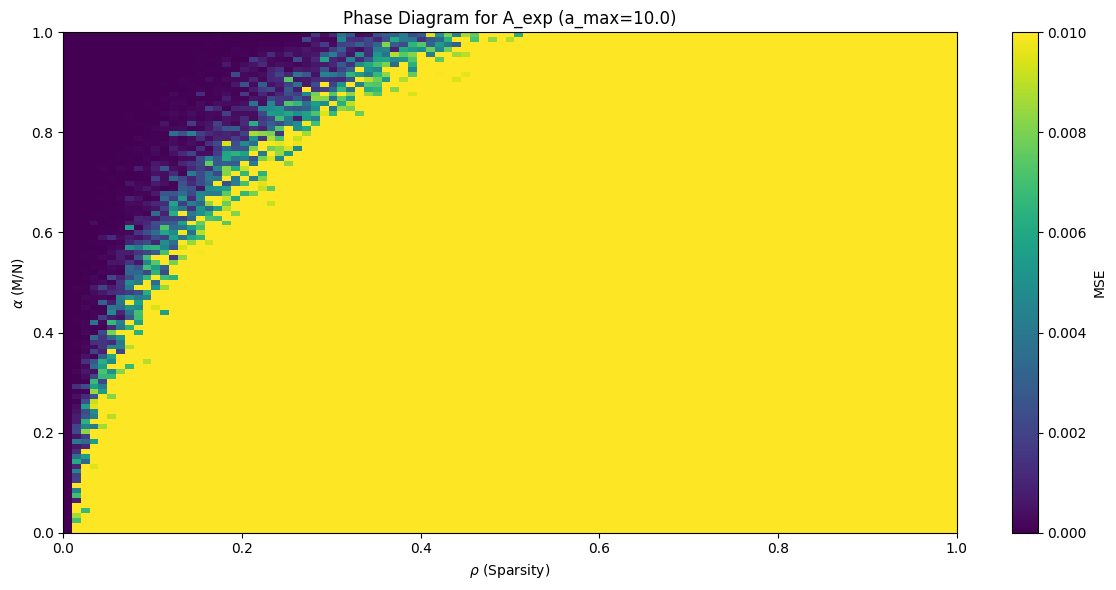

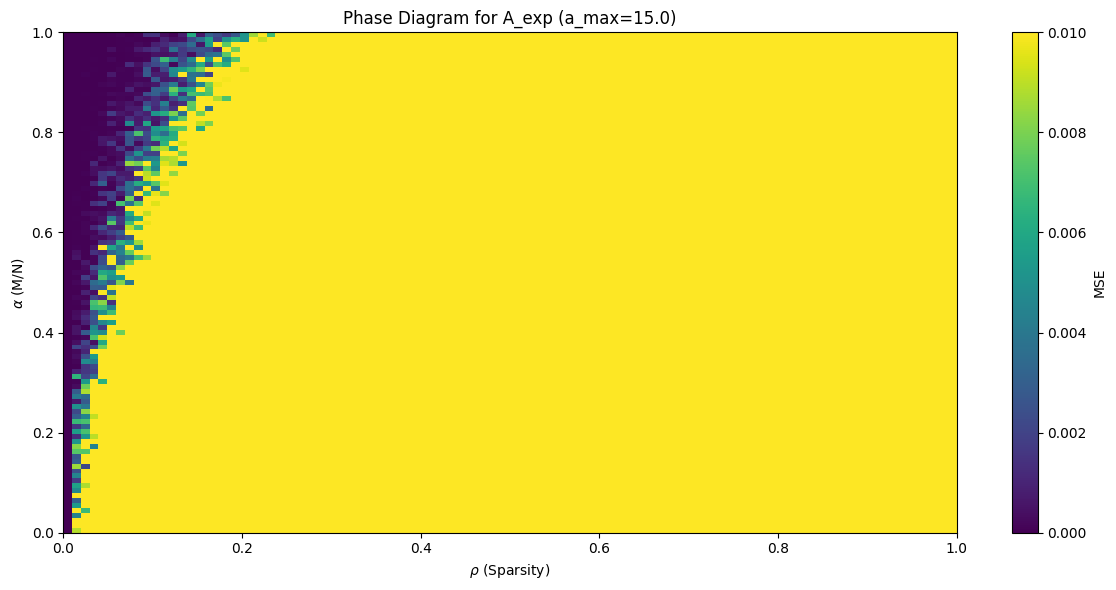

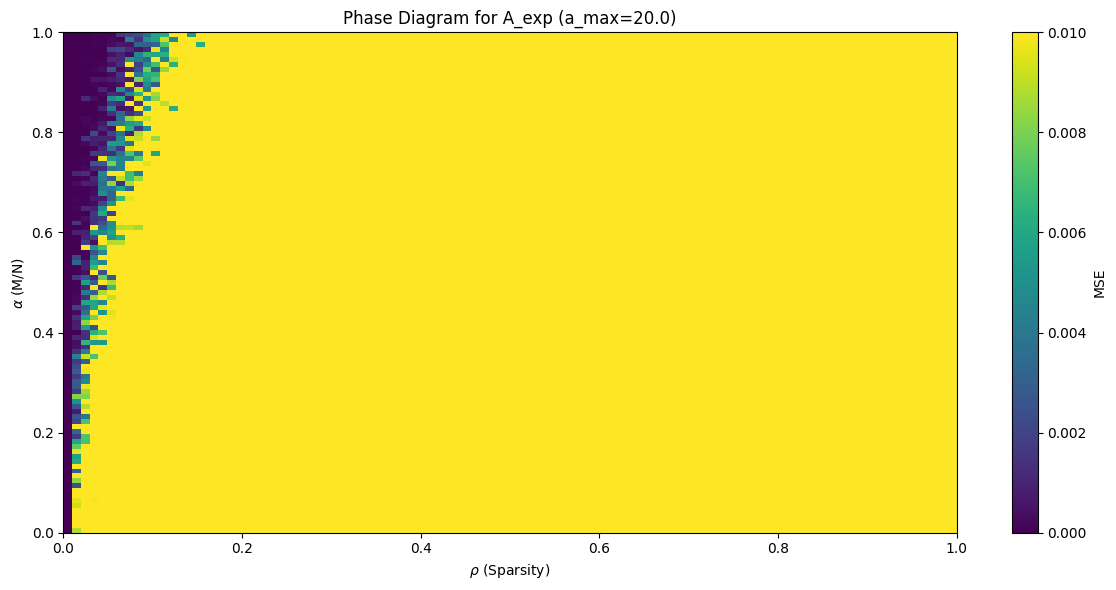

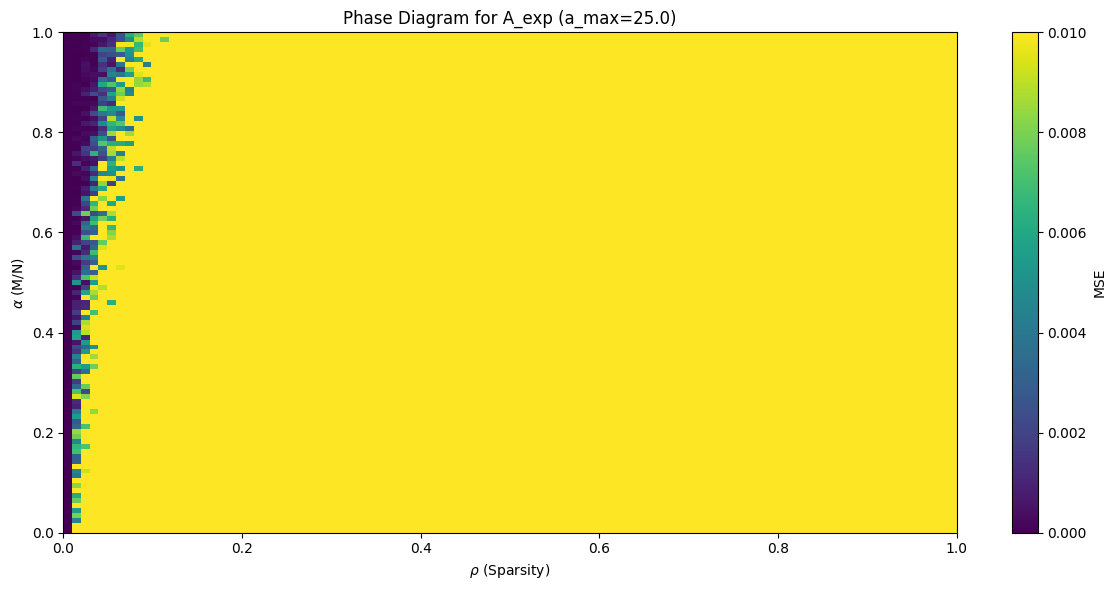

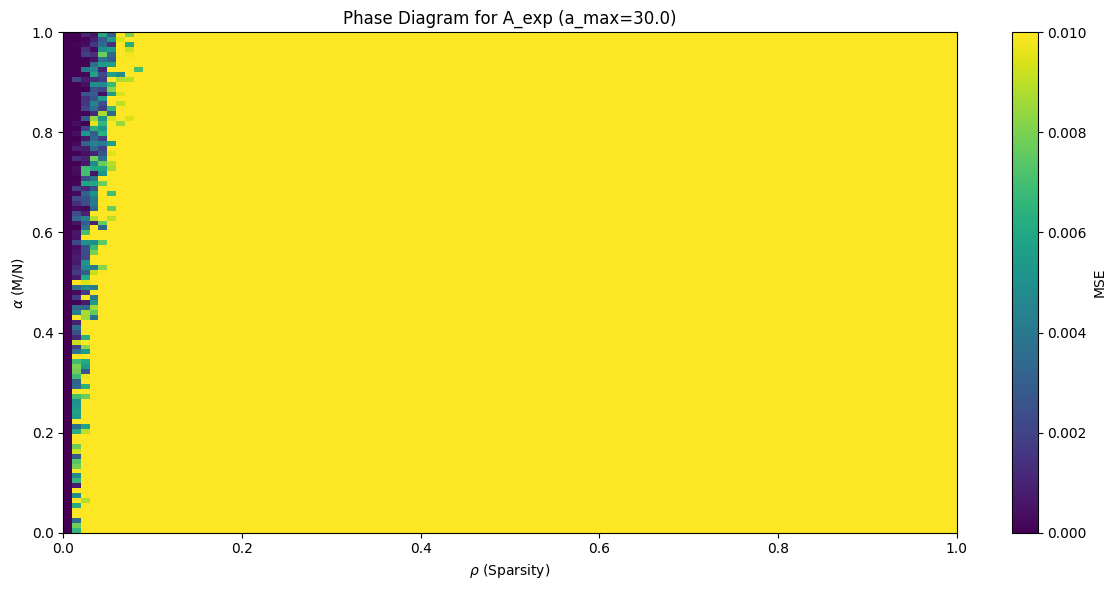

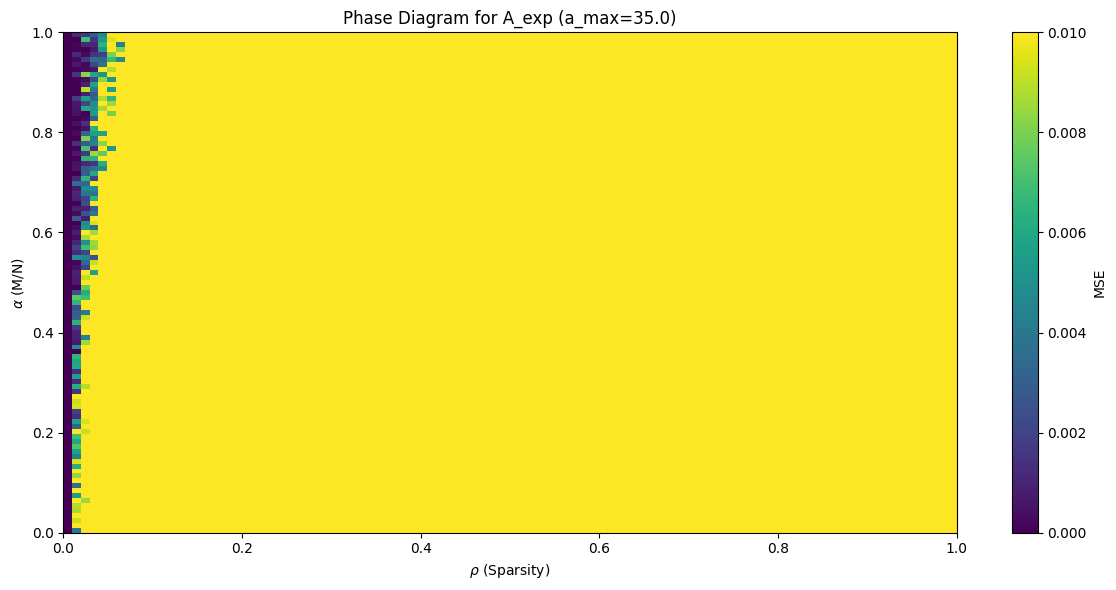

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ρとMの範囲
rho_values = np.arange(0.0, 1.01, 0.01)
M_values = np.arange(0, 101, 1)
N = 100
alpha_values = M_values / N

# 縮小するaの範囲
a_values = np.arange(0, 35.1, 5)

# インスタンスの数
num_instances = 10

# 繰り返し計算
for a_max in a_values:
    # 結果を保存する配列
    phase_diagram_A_exp = np.zeros((len(alpha_values), len(rho_values)))
    # 繰り返し計算
    for i, rho in enumerate(rho_values):
        for j, M in enumerate(M_values):
            mse_instances = []
            for _ in range(num_instances):
                # 原信号x0の設定
                x0 = np.random.randn(N)
                mask = (np.random.rand(N) < rho)
                x0 = mask * x0

                # 観測行列Aの設定
                A = np.random.randn(M, N)

                # Aの特異値分解
                U, S, Vt = np.linalg.svd(A, full_matrices=False)

                # 特異値を指数関数的に縮小し、A_expを設定
                a = np.linspace(0, a_max, min(M, N))
                lam = np.exp(-a)
                S_exp = S * lam
                A_exp = U @ np.diag(S_exp) @ Vt

                # 観測信号yの設定
                y = A.dot(x0)
                y_exp = A_exp.dot(x0)

                # 初期設定
                x_ = np.zeros(N)

                # ADMMを実行
                x_, mse_list_A_exp = opt_admm(x_, y_exp, A_exp, x0, Tall=10)

                # インスタンスのMSEを保存
                mse_instances.append(mse_list_A_exp[-1])

            # 複数インスタンスの平均MSEを保存
            phase_diagram_A_exp[j, i] = np.mean(mse_instances)

    # 相図を作成
    plt.figure(figsize=(12, 6))
    # A_expの相図
    plt.imshow(phase_diagram_A_exp, extent=[rho_values.min(), rho_values.max(), alpha_values.min(), alpha_values.max()], aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1e-2)
    plt.colorbar(label='MSE')
    plt.xlabel(r'$\rho$ (Sparsity)')
    plt.ylabel(r'$\alpha$ (M/N)')
    plt.title(f'Phase Diagram for A_exp (a_max={a_max})')

    plt.tight_layout()
    plt.show()


In [22]:
import concurrent.futures

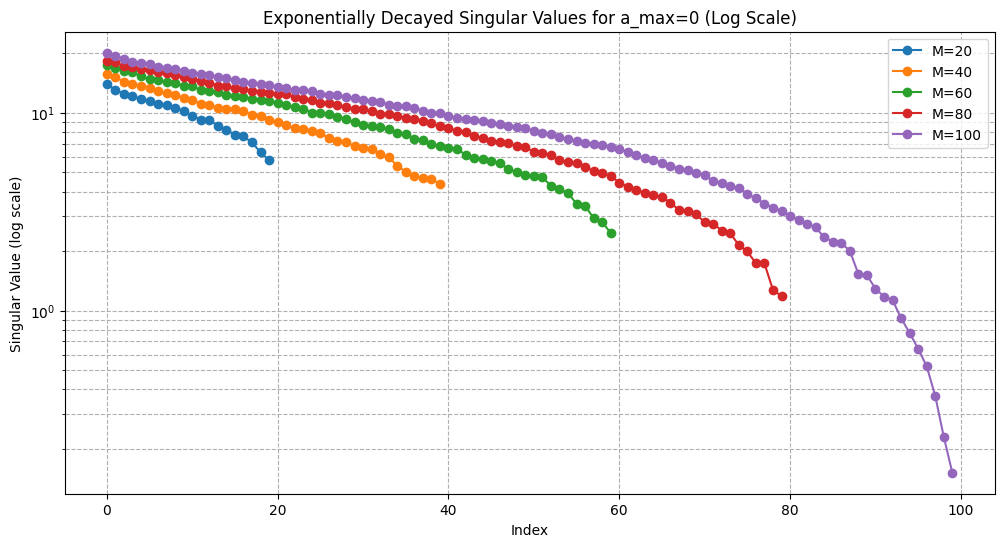

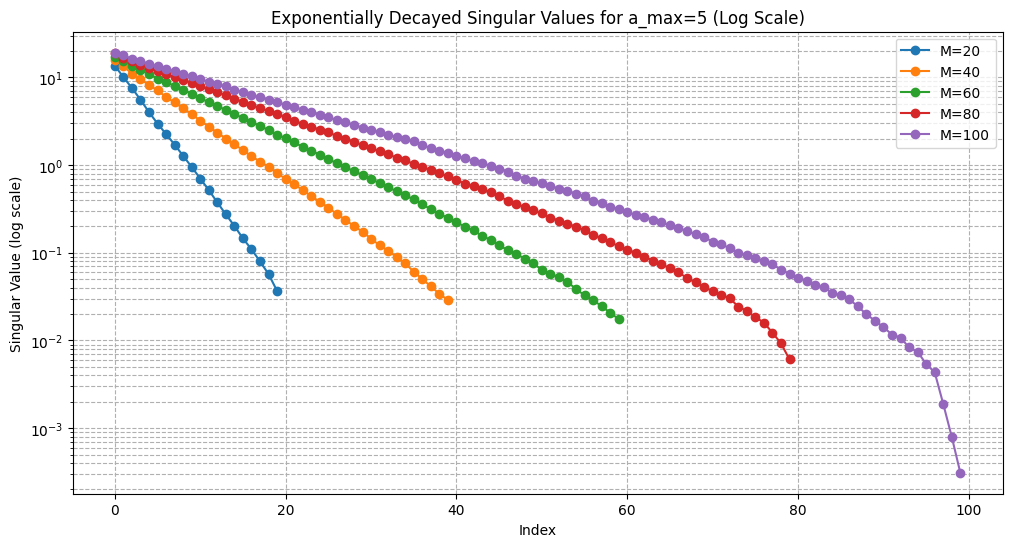

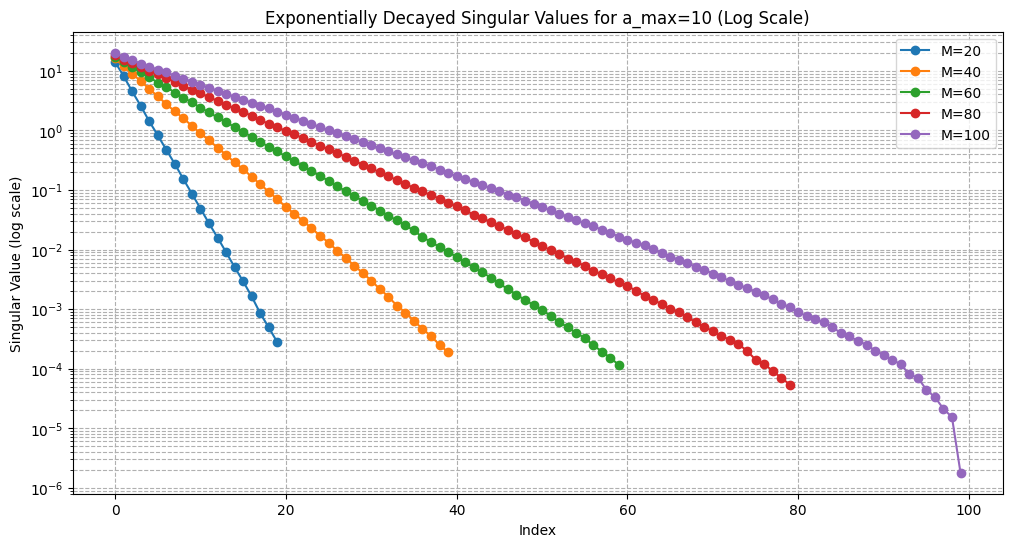

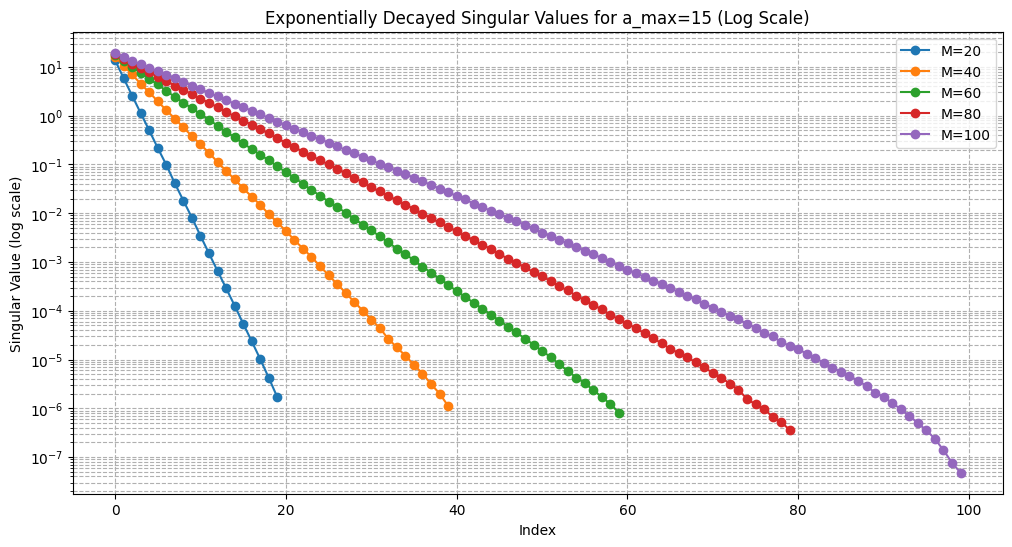

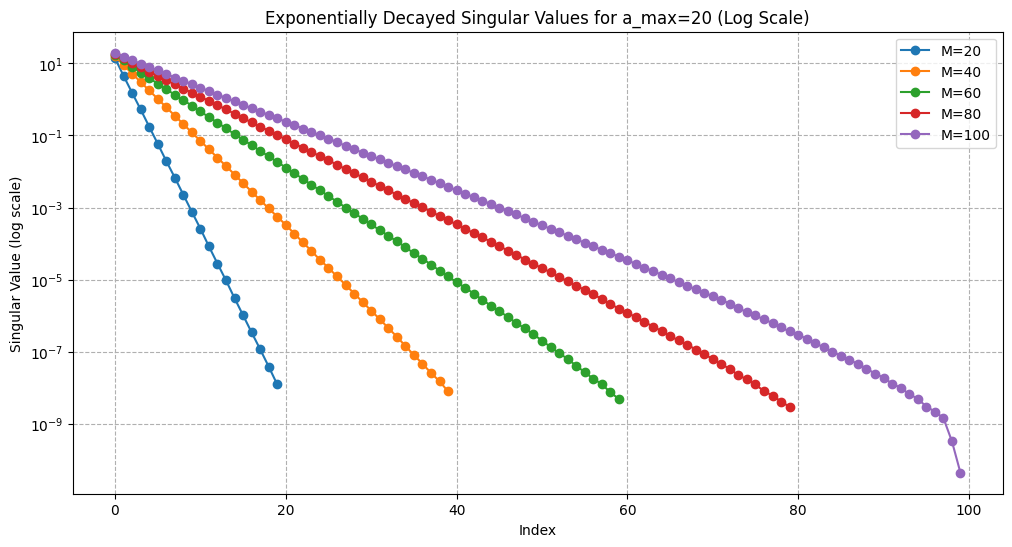

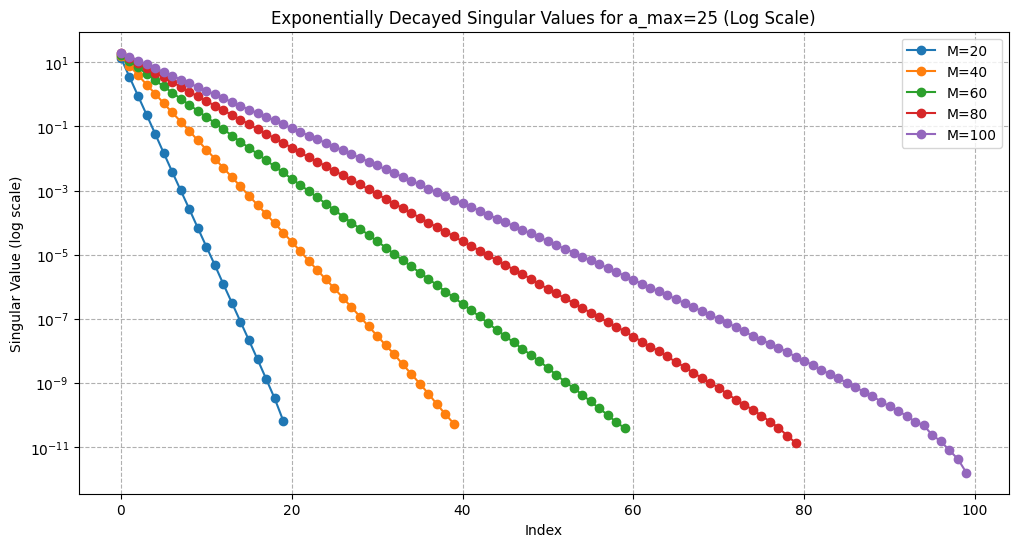

In [23]:
# 使用例
a_max_values = range(0, 26, 5)
M_values = range(20, 101, 20)
plot_singular_values_exponential_decay(a_max_values, M_values)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# パラメータの設定
M = 30
N = 100
ep = 1e-6

# 原信号x0の設定
rho = 0.1
x0 = np.random.randn(N)
mask = (np.random.rand(N) < rho)
x0 = mask * x0

# 観測行列Aの設定
A = np.random.randn(M, N)

# Aの特異値分解
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# 特異値を指数関数的に減少させ、観測行列A_expの構成
a = np.linspace(0, 20, min(M, N))
lam = np.exp(-a)
S_exp = S * lam
A_exp = U @ np.diag(S_exp) @ Vt

# 観測信号yの設定
y_exp = A_exp.dot(x0)

# 軟判定閾値関数の設定
def SoftThr(v, thr):
    z = np.zeros(len(v))
    itemp = np.where(v > thr)
    z[itemp] = v[itemp] - thr
    itemp = np.where(v <= -thr)
    z[itemp] = v[itemp] + thr
    return z

def opt_admm(x, y, A, x0, Tall=10, p=10.0, flag=True, use_svd=False):
    M, N = A.shape  # Aのサイズを取得
    if use_svd:
        # SVDを使用してy->U^Ty, A_exp->S_exp, x->x' として処理
        U, S, Vt = np.linalg.svd(A, full_matrices=False)
        y = U.T.dot(y)
        A = np.diag(S)
        Vt = Vt
    else:
        Atemp = A.dot(A.T) + ep * np.eye(M)
        Ainv = np.linalg.inv(Atemp)
        A = A.T.dot(Ainv)

    # 更新パラメータの設定
    Nvec = len(x)
    z = np.zeros(Nvec)
    u = np.zeros(Nvec)
    mse_list = []

    # 更新パラメータx, z, uの更新則
    for t in range(Tall):
        if use_svd:
            x = np.linalg.solve(A.T @ A + np.eye(Nvec), A.T @ y + z - u)
            z = SoftThr(Vt @ x - u, 1 / p)
            u = u + (z - Vt @ x)
        else:
            x = A.dot(y) + (np.eye(Nvec) - A.dot(A)).dot(z + u)
            z = SoftThr(x - u, 1 / p)
            u = u + (z - x)

        # 平均二乗誤差
        mse = np.mean((x - x0) ** 2)
        mse_list.append(mse)

    if use_svd:
        x = Vt.T @ x  # x'を元の空間に戻す
    return x, mse_list

# 実行例（条件追加前）
x_ = np.zeros(N)
x_, exp_mse_list = opt_admm(x_, y_exp, A_exp, x0, Tall=100, use_svd=False)

# 実行例（条件追加後）
x_svd = np.zeros(N)
x_svd, svd_mse_list = opt_admm(x_svd, y_exp, A_exp, x0, Tall=100, use_svd=True)

# 結果の比較
plt.plot(exp_mse_list, label='Before SVD')
plt.plot(svd_mse_list, label='After SVD')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()


ValueError: shapes (100,30) and (100,30) not aligned: 30 (dim 1) != 100 (dim 0)

In [ ]:

# パラメータの設定
M = 30
N = 100
ep = 1e-6

# 原信号x0の設定
rho = 0.1
x0 = np.random.randn(N)
mask = (np.random.rand(N) < rho)
x0 = mask * x0

# 観測行列Aの設定
A = np.random.randn(M, N)

# Aの特異値分解
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# 特異値を指数関数的に減少させ、観測行列A_expの構成
a = np.linspace(0, 20, min(M, N))
lam = np.exp(-a)
S_exp = S * lam
A_exp = U @ np.diag(S_exp) @ Vt

# 観測信号yの設定
y_exp = A_exp.dot(x0)

# 軟判定閾値関数の設定
def SoftThr(v, thr):
    z = np.zeros(len(v))
    itemp = np.where(v > thr)
    z[itemp] = v[itemp] - thr
    itemp = np.where(v <= -thr)
    z[itemp] = v[itemp] + thr
    return z

def opt_admm(x, y, A, x0, Tall=10, p=10.0, use_svd=False):
    M, N = A.shape  # Aのサイズを取得
    if use_svd:
        # SVDを使用してy->U^Ty, A_exp->S_exp, x->x' として処理
        U, S, Vt = np.linalg.svd(A, full_matrices=False)
        y = U.T.dot(y)
        A = np.diag(S)
    else:
        Atemp = A.dot(A.T) + ep * np.eye(M)
        Ainv = np.linalg.inv(Atemp)
        A = A.T.dot(Ainv)

    # 更新パラメータの設定
    Nvec = len(x)
    z = np.zeros(Nvec)
    u = np.zeros(Nvec)
    mse_list = []

    # 更新パラメータx, z, uの更新則
    for t in range(Tall):
        if use_svd:
            x = np.linalg.solve(A.T @ A + np.eye(Nvec), A.T @ y + z - u)
            z = SoftThr(x - u, 1 / p)
            u = u + (z - x)
        else:
            x = A.dot(y) + (np.eye(Nvec) - A.dot(A)).dot(z + u)
            z = SoftThr(x - u, 1 / p)
            u = u + (z - x)

        # 平均二乗誤差
        mse = np.mean((x - x0) ** 2)
        mse_list.append(mse)

    if use_svd:
        x = Vt.T @ x  # x'を元の空間に戻す
    return x, mse_list

# 実行例（条件追加前）
x_ = np.zeros(N)
x_, exp_mse_list = opt_admm(x_, y_exp, A_exp, x0, Tall=100, use_svd=False)

# 実行例（条件追加後）
x_svd = np.zeros(N)
x_svd, svd_mse_list = opt_admm(x_svd, y_exp, A_exp, x0, Tall=100, use_svd=True)

# 結果の比較
plt.plot(exp_mse_list, label='Before SVD')
plt.plot(svd_mse_list, label='After SVD')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()


ValueError: shapes (100,30) and (100,30) not aligned: 30 (dim 1) != 100 (dim 0)

# ノイズあり圧縮センシング
出力yにガウスノイズを加える